## Set up simple flow

Move current directory to project root

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

if 'project_root' not in dir():
    project_root = Path.cwd().parent
    
os.chdir(project_root)

Toy dataset

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from model_zoo.datasets.generated import Sphere
from model_zoo.datasets.utils import OmitLabels

dataset = Sphere('', 'test', manifold_dim=1, ambient_dim=2, mu=np.array([-3, -3]))
device = 'cpu' if not torch.cuda.is_available() else 'cuda:0'
dataset = dataset.to(device)
data_vec = dataset.x
dataloader = DataLoader(OmitLabels(dataset), batch_size=50)

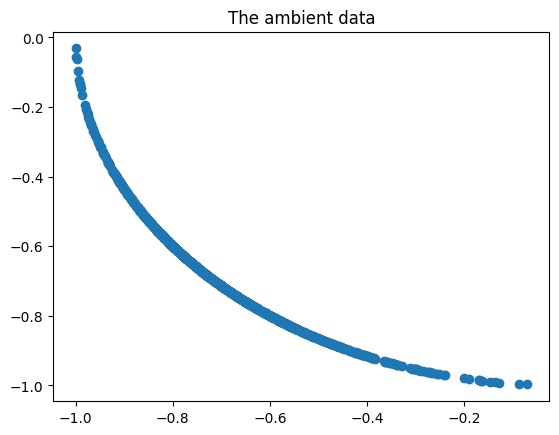

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(dataset.x.cpu()[:, 0], dataset.x.cpu()[:, 1])
plt.title("The ambient data")
plt.show()

Construct a flow consisting of one simple linear transformation

In [5]:
from torch import optim
from model_zoo.density_estimator.flow import NormalizingFlow

flow = NormalizingFlow(
    dim=2,
    transform=[{
        'class_path': 'nflows.transforms.lu.LULinear',
        'init_args': {
            'features': 2
        }
    }],
).to(device)

optimizer = optim.Adam(flow.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda step: 1
)

flow.optimizer = optimizer
flow.lr_scheduler = scheduler

Train the flow

In [6]:
from tqdm import tqdm
for epoch in tqdm(range(1000), desc="Training the flow model"):
    for batch in dataloader:
        flow.train_batch(batch)
    

Training the flow model:   0%|          | 0/1000 [00:00<?, ?it/s]

Training the flow model: 100%|██████████| 1000/1000 [00:42<00:00, 23.31it/s]


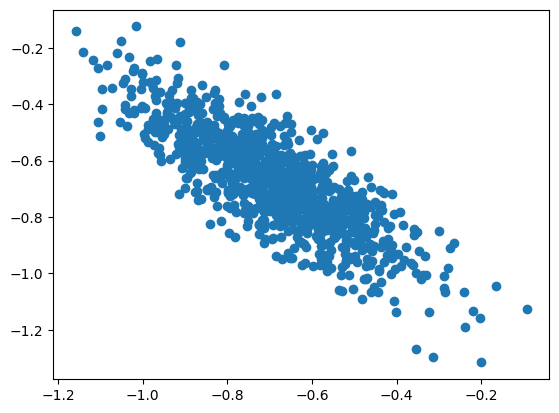

In [7]:

gen_sample = flow.sample(1000).cpu().detach()
plt.scatter(gen_sample[:, 0], gen_sample[:, 1])

Evaluate 

In [8]:
from ood.methods.linear_approximations.latent_statistics import EllipsoidCDFStatsCalculator
from ood.methods.linear_approximations.encoding_model import EncodingFlow


ellipsoid_calc = EllipsoidCDFStatsCalculator(
    flow, 
    encoding_model_class = EncodingFlow, 
    encoding_model_args = {
        'use_functorch': True, 
        'use_forward_mode': True, 
        'use_vmap': True
    }, 
    verbose=1
)
# create a dataloader out of the first 3 batches of dataloader
sampling_loader = torch.utils.data.DataLoader(
    dataloader.dataset[np.random.randint(0, len(dataloader.dataset), size=10)],
    batch_size=2,
)
jax, z_values = ellipsoid_calc.encoding_model.calculate_jacobian(
    loader=sampling_loader,
    stack_back=True,
)

In [9]:
for x_, z_, jac_ in zip(sampling_loader, z_values, jax):
    for x, z, jac in zip(x_, z_, jac_):
        x = x.to(device)
        z = z.to(device)
        jac = jac.to(device)
        
        u = torch.randn_like(x)
        x_perturbed = x + u
        z_perturbed = ellipsoid_calc.encoding_model.encode(x_perturbed.unsqueeze(0)).squeeze(0)
        
        print("---")
        print("J =", jac)
        print(
            "linear approx",
            (x + (jac @ (z_perturbed - z).reshape(-1, 1)).flatten()).tolist(), 
            "= x*", 
            x_perturbed.tolist()
        )
        print(
            "delta", 
            (x + (jac @ (z_perturbed - z).reshape(-1, 1)).flatten() - x_perturbed).tolist()
        )
        print("u =", u.tolist())
        print("x =", x.tolist())
        print("***")
    

---
J = tensor([[ 0.1597, -0.0582],
        [-0.0975,  0.1418]], device='cuda:0')
linear approx [-0.5620883107185364, 0.8402486443519592] = x* [-0.5620883107185364, 0.8402485251426697]
delta [0.0, 1.1920928955078125e-07]
u = [0.15169496834278107, 1.540615200996399]
x = [-0.7137832641601562, -0.7003666758537292]
***
---
J = tensor([[ 0.1597, -0.0582],
        [-0.0975,  0.1418]], device='cuda:0')
linear approx [-0.6919758915901184, -1.28086519241333] = x* [-0.6919758319854736, -1.2808654308319092]
delta [-5.960464477539063e-08, 2.384185791015625e-07]
u = [-0.3498194217681885, -0.34122246503829956]
x = [-0.34215644001960754, -0.9396430253982544]
***
---
J = tensor([[ 0.1597, -0.0582],
        [-0.0975,  0.1418]], device='cuda:0')
linear approx [-2.0146913528442383, -1.9064431190490723] = x* [-2.123842239379883, -1.810305118560791]
delta [0.10915088653564453, -0.09613800048828125]
u = [-1.519209861755371, -1.0138003826141357]
x = [-0.6046323776245117, -0.7965046763420105]
***
---
J = tens

In [10]:


ellipsoid_samples = ellipsoid_calc.sample(0.01, sampling_loader, 1000)

sampling from ellipsoids: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


In [11]:
print(len(ellipsoid_samples))
print(ellipsoid_samples[0].shape)

10
torch.Size([1000, 2])


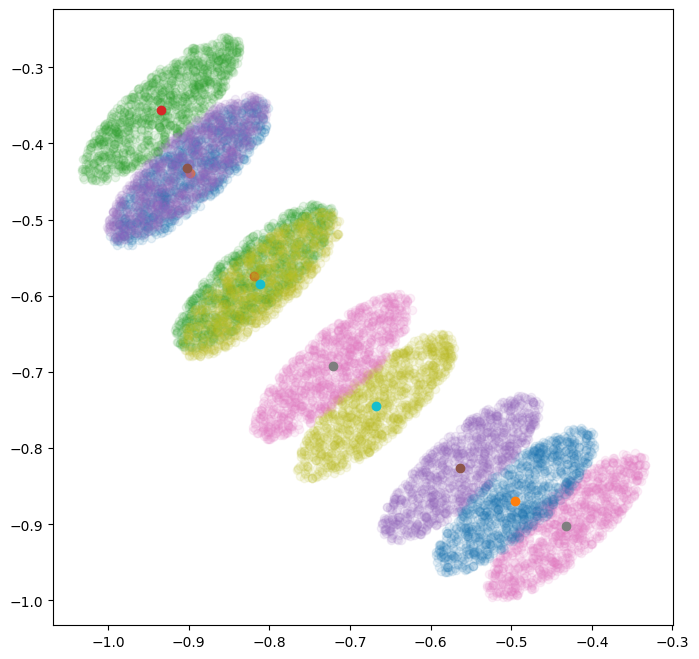

In [12]:
plt.figure(figsize=(8, 8))
for sample, dvec in zip(ellipsoid_samples, data_vec):
    plt.scatter(sample[:, 0].cpu(), sample[:, 1].cpu(), alpha=0.1)
    plt.scatter(dvec[:1].cpu(), dvec[1:].cpu()) 
plt.show()